In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
from torch import utils as t_utils
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cpu")


In [3]:

train_data = pd.read_csv('./data/train.csv',dtype = np.float32)

train_data['label'] = train_data['label'].astype(int)
# test_data['label'] = test_data['label'].astype(int)

# convert to numpy
targets_numpy = train_data.label.values
features_numpy = train_data.loc[:,train_data.columns != "label"].values

# convert to tensor
targets_tensor = torch.from_numpy(targets_numpy).long()
features_tensor = torch.from_numpy(features_numpy).float()

# create dataset
dataset = TensorDataset(features_tensor, targets_tensor)
 
# split dataset
rows = train_data.shape[0]
test_size = int(rows*0.2)
train_size = rows - test_size
trainDataset, testDataset = random_split(dataset, [train_size, test_size])

# init loaders
batch_size = 100
trainLoader = DataLoader(trainDataset, batch_size=batch_size)
testLoader = DataLoader(testDataset, batch_size=batch_size)

In [186]:
# simpleModel = nn.Linear(28*28, 10)
# simpleModel.to(device)

# X, y = next(iter(trainLoader))

# pred = simpleModel(X)

# loss_fn = nn.CrossEntropyLoss()
# print(pred.size())
# print(y.size())
# print(pred.dtype)
# print(y.dtype)
# a = loss_fn(pred, y.long())
# print(a)

torch.Size([100, 10])
torch.Size([100])
torch.float32
torch.float32
tensor(66.3773, grad_fn=<NllLossBackward0>)


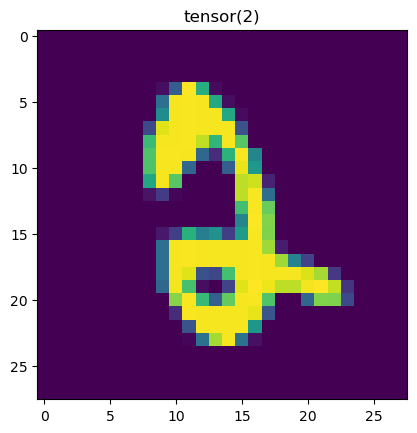

Label: 2


In [8]:
train_features, train_labels = next(iter(trainLoader))
img = torch.reshape(train_features[0], (28, 28)) 
label = train_labels[0]
plt.imshow(img)
plt.title(str(label))
plt.show()
print(f"Label: {label}")

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Conv2d(kernel_size=3, stride=1, padding=0, in_channels=1, out_channels=16),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            
            # nn.Linear(32*4*4, 10),

            nn.Linear(28*28, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            # nn.Linear(512, 10)
        )

        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        # print('forward1')
        # print(x.size())
        # self.linear.weight = self.linear.weight.long()
        # print(self.linear.weight.dtype)
        # print(self.linear.bias.dtype)
        # print(x.dtype)
        # x = self.flatten(x)
        # print('forward2')
        logits = self.linear(x)
        
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    count = 0
    for (X, y) in trainLoader:
        # train_features, train_labels = next(iter(trainLoader))
        X, y = X.to(device), y.to(device)
        # print(X.size())
         
        # xx = torch.reshape(X, (100, 1, 28, 28)) 
        # Compute prediction error
        pred = model(X)
        # print(pred )
        # print(pred.size())
        # print(y.size())
        # print(y)
        # aa = torch.rand(100, 1).to(device)
        # print('pred.dtype ', pred.dtype)
        # print('y.dtype ',y.dtype)
        loss = loss_fn(pred , y )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count = count + 1
        if count % 200 == 0:
            loss, current = loss.item(), (X[0] + 1) * len(X)
          
            print(f"loss: {loss:>7f}")

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainDataset, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 13.557081
Epoch 2
-------------------------------
loss: 8.252522
Epoch 3
-------------------------------
loss: 11.545628
Epoch 4
-------------------------------
loss: 9.626928
Epoch 5
-------------------------------
loss: 11.675030
Done!


In [11]:
loss_fn2 = nn.CrossEntropyLoss()
total = 0
correct = 0
for (X, y) in testLoader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    print(torch.max(pred.data, 1))
    predicted = torch.max(pred.data, 1)[1]
    total += len(y)
    correct += (predicted == y).sum()
    loss = loss_fn2(pred , y )
    break

accuracy = 100 * correct / float(total)

print(f'Accuracy of the network on the {total} test images: %d %%' % (accuracy)) 

torch.return_types.max(
values=tensor([272.1061, 271.1751, 517.4122, 528.0822, 278.5352, 568.5839, 240.7857,
        638.0223, 695.2358, 218.3727, 438.5016, 474.5107, 291.6537, 652.0610,
        409.5823, 599.7414, 673.8172, 541.4721, 744.4849, 276.4359, 280.8676,
        233.4733, 365.0594, 232.5797, 458.9490, 446.0239, 590.9725, 574.6077,
        219.6477, 609.9771, 321.8040, 360.8820, 173.0140, 378.3975, 350.7424,
        659.6085, 417.9348, 184.1626, 381.0302, 536.7430, 530.1068, 603.9327,
        528.3693, 557.4277, 209.2258, 414.1646, 269.4227, 376.1413, 348.9856,
        752.3542, 471.1986, 443.2898, 297.4408, 584.8267, 333.7521, 400.8976,
        421.3727, 441.9293, 753.2368, 324.3586, 519.4559, 260.6520, 314.1537,
        401.2942, 361.5834, 321.9950, 410.5527, 259.8308, 157.7250, 470.2353,
        233.4984, 447.7524, 444.1805, 250.6725, 597.0807, 584.0529, 187.0855,
        514.9391, 353.4236, 779.4355, 355.3369, 273.7224, 370.7678, 593.5024,
        776.9108, 820.0756, 979.6